In [8]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import boto3
import pandas as pd
from dotenv import load_dotenv
import os
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import warnings
import numpy as np
from mlflow.models.signature import infer_signature
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [10]:
load_dotenv()

access_key = os.getenv("AWS_ACCESS_KEY_ID")
secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
s3_url = os.getenv("MLFLOW_S3_ENDPOINT_URL")
tracker_url = os.getenv("MLFLOW_URL")
os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("MLFLOW_S3_ENDPOINT_URL")
os.environ["MLFLOW_TRACKING_USERNAME"] = os.getenv("MLFLOW_ADMIN_USERNAME")
os.environ["MLFLOW_TRACKING_PASSWORD"] = os.getenv("MLFLOW_ADMIN_PASSWORD")
os.environ["MLFLOW_S3_IGNORE_TLS"] = "true"
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"
bucket_name = "dataset"
object_name = "water_potability.csv"

In [41]:
data = pd.read_csv("data/water_potability.csv")

## For updating data

In [ ]:
# data['Solids'] = (data['Solids'] - data['Solids'].min()) / (data['Solids'].max() - data['Solids'].min()) * 1000
# data.to_csv("data/water_potability.csv")

In [15]:
df = data[['ph','Solids','Potability']]

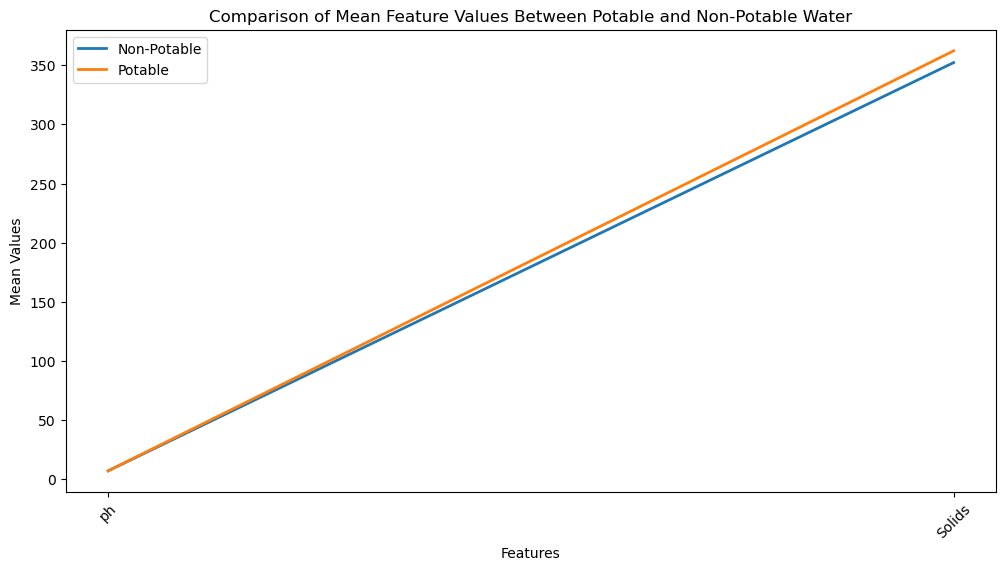

In [28]:
import matplotlib.pyplot as plt

# Calculate the means for each feature grouped by Potability
mean_values = df.groupby('Potability').mean().transpose()

# Plotting the means with solid lines
plt.figure(figsize=(12, 6))
plt.plot(mean_values[0], label='Non-Potable', linestyle='-', linewidth=2)
plt.plot(mean_values[1], label='Potable', linestyle='-', linewidth=2)
plt.xlabel("Features")
plt.ylabel("Mean Values")
plt.title("Comparison of Mean Feature Values Between Potable and Non-Potable Water")
plt.xticks(rotation=45)
plt.legend()
plt.show()


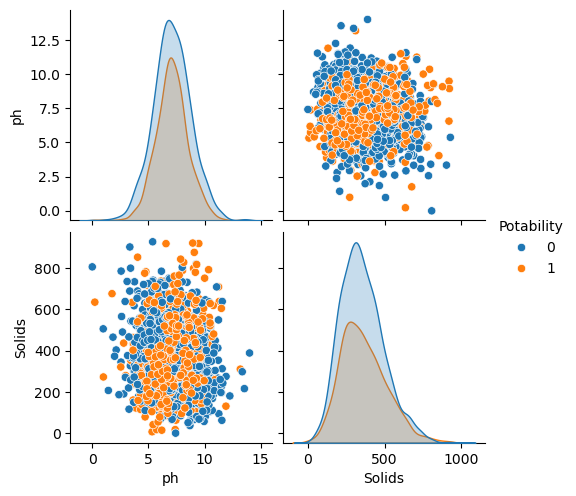

In [31]:
# Misalkan kita memilih dua fitur, misalnya 'pH' dan 'Sulfate'
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, hue='Potability')
plt.show()

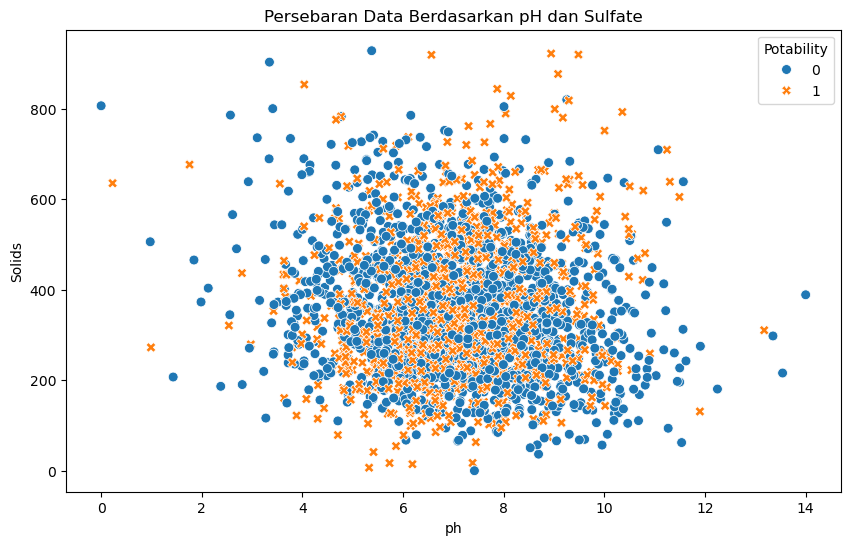

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ph', y='Solids', hue='Potability', style='Potability', s=50)
plt.title("Persebaran Data Berdasarkan pH dan Sulfate")
plt.xlabel("ph")
plt.ylabel("Solids")
plt.legend(title="Potability", loc="upper right")
plt.show()

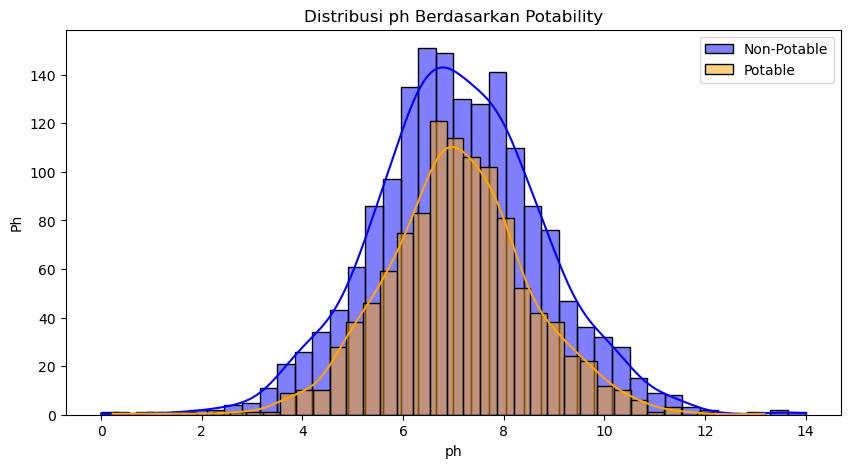

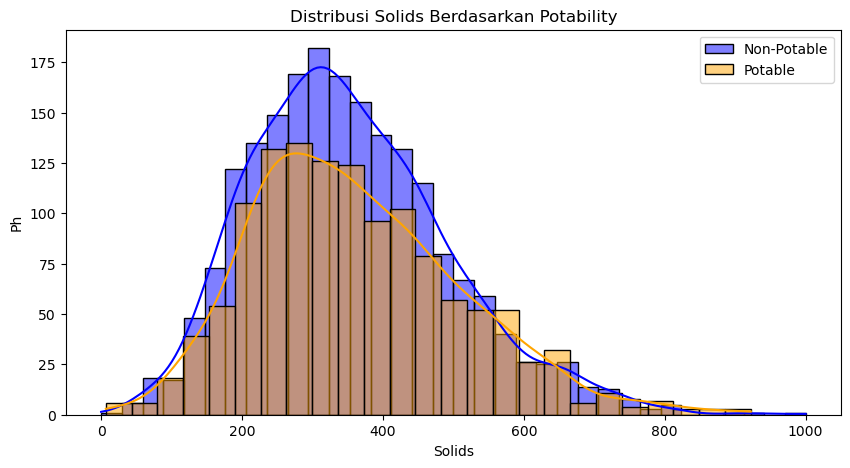

In [42]:
features = df.columns.drop('Potability')
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[df['Potability'] == 0][feature], kde=True, color="blue", label="Non-Potable")
    sns.histplot(df[df['Potability'] == 1][feature], kde=True, color="orange", label="Potable")
    plt.title(f'Distribusi {feature} Berdasarkan Potability')
    plt.xlabel(feature)
    plt.ylabel("Ph")
    plt.legend()
    plt.show()


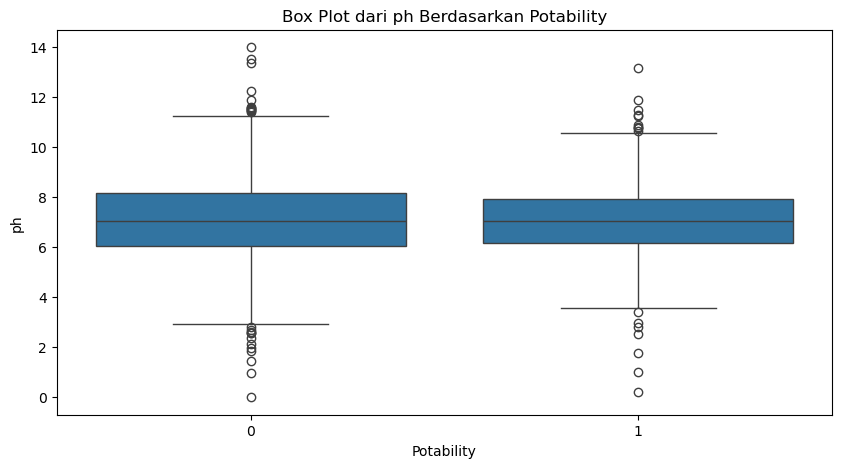

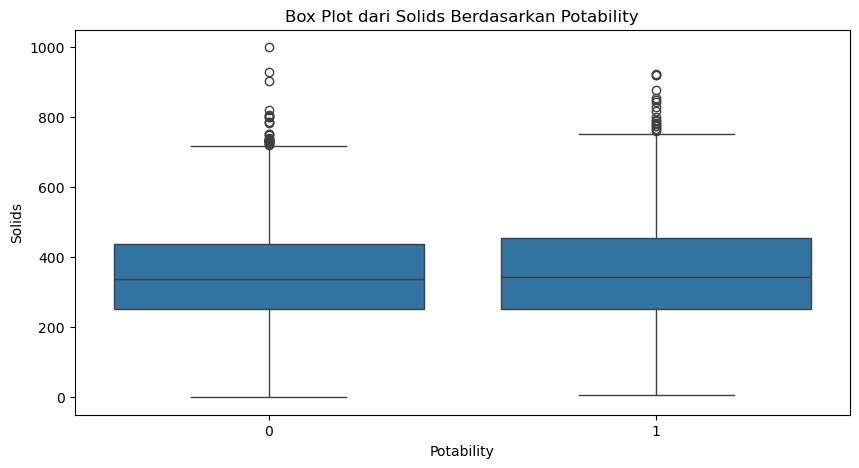

In [40]:
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Potability', y=feature, data=df)
    plt.title(f'Box Plot dari {feature} Berdasarkan Potability')
    plt.show()


In [16]:
df.describe()

,ph,Solids,Potability
count,2785.000000,3276.000000,3276.000000
mean,7.080795,356.172785,0.390110
std,1.594320,143.968318,0.487849
min,0.000000,0.000000,0.000000
25%,6.093092,251.956849,0.000000
50%,7.036752,338.337853,0.000000
75%,8.062066,443.498295,1.000000
max,14.000000,1000.000000,1.000000


In [17]:
mlflow.set_tracking_uri(tracker_url)
experiment_name = "water_potability"
mlflow.set_experiment(experiment_name)

data = df.drop('Potability', axis=1)
target = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [45]:
# Model parameters
n_estimators = 200  
max_depth = 10
random_state = 42 
learning_rate = 0.1
subsample = 0.8
colsample_bytree = 0.8


with mlflow.start_run():
    # Log parameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("subsample", subsample)
    mlflow.log_param("colsample_bytree", colsample_bytree)

    # Initialize and train the model
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    # Evaluate the model
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    mlflow.log_metric("accuracy", accuracy)

    # Define input example and signature
    input_example = X_test.iloc[:1].fillna(X_test.mean())
    signature = infer_signature(X_test, model.predict(X_test))

    # Log the model with MLflow
    mlflow.xgboost.log_model(
        model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

    # Print run information
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")
    print(f"Model accuracy: {accuracy}")


2024/11/14 17:49:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/11/14 17:49:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/fauzanghaza/Applications/miniconda3/envs/MLOps/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:49:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/11/14 17:49:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-ram-130 at: http://10.34.4.198:5000/#/experiments/1/runs/2810f093899d4a9bb077ad38ad76060b.
2024/11/14 17:49:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment 

Run ID: 2810f093899d4a9bb077ad38ad76060b
Model accuracy: 0.5685975609756098


2024/11/14 17:49:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/11/14 17:49:17 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [19]:
import mlflow.pyfunc

model_uri = f"runs:/{run_id}/model"
model = mlflow.pyfunc.load_model(model_uri)

# Check if metadata and signature are available
if model.metadata:
    print("Model signature:", model.metadata.get_input_schema())
else:
    print("Model metadata is missing.")

Model signature: ['ph': double (optional), 'Solids': double (required)]


In [46]:
# Model parameters for RandomForestClassifier
n_estimators = 300
max_depth = None
random_state = 42
min_samples_split = 2
min_samples_leaf = 1
max_features = 'sqrt'
bootstrap = True

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("min_samples_split", min_samples_split)
    mlflow.log_param("min_samples_leaf", min_samples_leaf)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("bootstrap", bootstrap)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    # Evaluate the model
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    mlflow.log_metric("accuracy", accuracy)

    # Define input example and signature
    input_example = X_test.iloc[:1].fillna(X_test.mean())
    signature = infer_signature(X_test, model.predict(X_test))

    # Log the model with MLflow
    mlflow.sklearn.log_model(
        model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

    # Print run information
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")
    print(f"Model accuracy: {accuracy}")


2024/11/14 17:50:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/11/14 17:50:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Run ID: f38fd8a8d2ad46a89d61de1fc3b71d0f
Model accuracy: 0.5716463414634146


2024/11/14 17:50:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-deer-618 at: http://10.34.4.198:5000/#/experiments/1/runs/f38fd8a8d2ad46a89d61de1fc3b71d0f.
2024/11/14 17:50:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://10.34.4.198:5000/#/experiments/1.
2024/11/14 17:50:40 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/11/14 17:50:40 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
